# Localization - Line Map - SMC Move

In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [2]:
#nbx
push!(LOAD_PATH, "src");
using BenchmarkTools;
using Colors, Plots;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using GridSlam
using Geometry
using MyUtils

In [5]:
include("src/unpack_data.jl");

Loading `data/data_3.jld2` ...

	_segs 	Vector{Segment}
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Tuple{Vector{Float64}, Float64}}
	_as 	Vector{Float64}
	_zs 	Vector{Any}
	_ss 	Vector{Vector{Measurement}}
	_fov 	Float64
	_zmax 	Int64
	_T 	Int64

To take a look call `glimpse_at_data(_segs, _ps, _ss)`


## Distributions we need

In [6]:
#nbx
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src")
using GenDistributionZoo: ProductDistribution, diagnormal

mvuniform = ProductDistribution(uniform);
mvuniform(zeros(5), ones(5))

5-element Vector{Float64}:
 0.5334400936303829
 0.6018272546468054
 0.09389127548868936
 0.5369744325849177
 0.2515986415023792

## Pose prior

In [59]:
#nbx

# Caution, model depends on `_ps`, a global variable.
# This isn't a "pure" function, in the 
# functional programming sense
@gen function pose_prior_model(x_noise=0.25, hd_noise=22.5)
    x  ~ diagnormal(_ps[1].x, [x_noise,x_noise])
    hd ~ normal(_ps[1].hd, hd_noise/360*2π)
    return Pose(x,hd)
end;

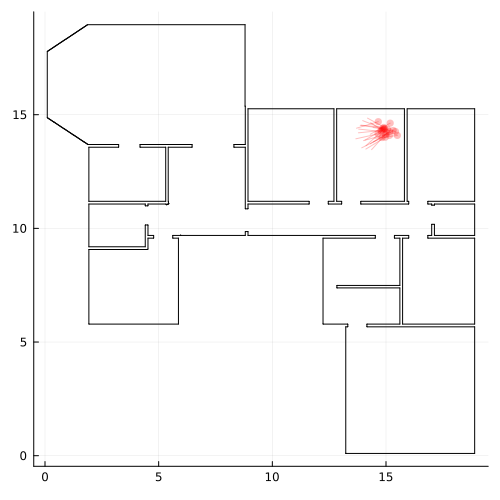

In [60]:
ps = [pose_prior_model() for t=1:20]
# -----------------
myplot = plot(size=(500,500), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
scatter!.(ps, alpha=0.25)
myplot

## Motion model

In [61]:
#nbx
"""
    q = motion_model(p, u)

Sample a new pose `q` given the previous pose `p`, and 
some control data `u = (dx, dhd)`.
"""
@gen function motion_model(p, u, x_noise=0.25, hd_noise=22.5)
    dx, dhd = u
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise/360*2π)
    return p = Pose(x, hd)
end;

In [62]:
x_noise=0.25
hd_noise=22.5;

motion_model(_ps[1], _us[1], x_noise, hd_noise)

Pose([14.723398338210256, 14.133729304220585], -2.140723597100462)

## Sensor model and map

The sensor model is the only part that depends on the map.
Since in this notebook we are only concerned with localization, not mapping,
we assume we are given a map of the environment. In this notebook the map is a
bunch of line segments stored in `_segs`.

In [41]:
include("src/cuda_raycaster_line_map.jl")

bench_cast! (generic function with 1 method)

In [43]:
sensor_mix_wrong = HeterogeneousMixture([diagnormal, mvuniform, mvuniform])

n = 5
args_wrong = ([0.4,0.3,0.3], zeros(n), ones(n), zeros(n), _zmax*ones(n), (_zmax-0.1)*ones(n), _zmax*ones(n))
z = sensor_mix_wrong(args_wrong...)
logpdf(sensor_mix_wrong, z, args_wrong...)

10.308952660647348

In [45]:
sensor_mix  = HeterogeneousMixture([normal, uniform, uniform])
sensor_dist = ProductDistribution(sensor_mix)
args = (fill([0.4,0.3,0.3], n), zeros(n), ones(n), zeros(n), _zmax*ones(n), (_zmax-0.1)*ones(n), _zmax*ones(n))
sensor_dist(args...)
logpdf(sensor_dist, z, args...)

5.517999150895674

In [153]:
function cast_GPU(p, segs_, a_)
    n = length(segs_)
    m = length(a_)

    z_ = CuArray(ones(m)*_zmax)
    p_ = CuArray([p.x;p.hd])


    blockdims = (32,8)
    griddims = cuda_grid((n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims cast!(segs_,a_,p_,z_)
    end
    return Array(z_)
end

cast_GPU (generic function with 1 method)

In [239]:
@gen function sensor_model(p, segs_, a_, std, dropout)

        z′ = cast_GPU(p, segs_, a_)
        m = length(a_)
        args = (
            fill([1.0-dropout-0.05, dropout, 0.05], m), # Mixture
            z′, std*ones(m),                            # diagnormal
            zeros(m), _zmax*ones(m),                    # mvuniform
            (_zmax-0.1)*ones(m), _zmax*ones(m)          # mvuniform
        );
        z ~ sensor_dist(args...)
        return z
end;

In [124]:
p = _ps[1]
segs_ = CuArray(stack(Geometry.vec.(_segs)))
a_ = CuArray(_a)
sensor_noise = 0.1
dropout = 0.1
sensor_model(p, segs_, a_, sensor_noise, dropout);

In [125]:
@btime sensor_model(p, segs_, a_, sensor_noise, dropout);

  361.035 μs (4760 allocations: 180.14 KiB)


```julia
352.035 μs (4760 allocations: 180.14 KiB)
```

In [69]:
ch = choicemap(:z => _zs[t])
@btime simulate(sensor_model, (p, segs_, a_, sensor_noise, dropout));
@btime generate(sensor_model, (p, segs_, a_, sensor_noise, dropout), ch);

  1.307 ms (20306 allocations: 693.30 KiB)
  1.028 ms (15613 allocations: 554.67 KiB)


```julia
1.307 ms (20306 allocations: 693.30 KiB)
1.028 ms (15613 allocations: 554.67 KiB)
```

In [71]:
S = 10
inds = 1:S:length(_a)
ch = choicemap(:z => _zs[t][inds])
@btime simulate(sensor_model, (p, segs_, a_[inds], sensor_noise, dropout));
@btime generate(sensor_model, (p, segs_, a_[inds], sensor_noise, dropout), ch);

  224.300 μs (2195 allocations: 78.17 KiB)
  190.063 μs (1714 allocations: 63.69 KiB)


```julia
224.300 μs (2195 allocations: 78.17 KiB)
190.063 μs (1714 allocations: 63.69 KiB)
```

In [72]:
S = 30
inds = 1:S:length(_a)
ch = choicemap(:z => _zs[t][inds])
@btime simulate(sensor_model, (p, segs_, a_[inds], sensor_noise, dropout));
@btime generate(sensor_model, (p, segs_, a_[inds], sensor_noise, dropout), ch);

  137.832 μs (851 allocations: 32.38 KiB)
  123.598 μs (682 allocations: 27.09 KiB)


```julia
137.832 μs (851 allocations: 32.38 KiB)
123.598 μs (682 allocations: 27.09 KiB)
```

## Static Model

In [155]:
#nbx
@gen function slam_kernel(t, state, segs_, a_, us, motion_noise, sensor_noise, dropout)
    
        p,_ = state
        u = us[t]
    
        p = {:pose}   ~ motion_model(p, u, motion_noise)
        z = {:sensor} ~ sensor_model(p, segs_, a_, sensor_noise, dropout) # GPU accelerated
        
    
    return (p, z)
end

slam_chain = Gen.Unfold(slam_kernel)
Gen.@load_generated_functions

In [156]:
#nbx
"""
    [(p,z),...] = static_slam_model(T, segs_, a_, us, motion_noise, sensor_noise, dropout, inds)

Static SLAM model ...
"""
@gen (static) function static_slam_model(T, segs_, a_, us, motion_noise, sensor_noise, dropout)
    
    # Start the Markov chain; 
    # No motion, just the prior
    p = { :pose   } ~ pose_prior_model()
    z = { :sensor } ~ sensor_model(p, segs_, a_, sensor_noise, dropout)  # GPU accelerated
    
    # Unfold the MArkov chain
    chain ~ slam_chain(T, (p,nothing), segs_, a_, us, motion_noise, sensor_noise, dropout)
    
    return [(p,z);chain]
end

Gen.@load_generated_functions

In [157]:
#nbx
function create_obs_choices(t::Int, zs::AbstractVector, inds::StepRange{Int64, Int64})
    ch = choicemap()
    if t==1
        addr  = :sensor => :z 
    else
        addr  = :chain => t-1 => :sensor => :z 
    end
    ch[addr]= zs[t][inds]
    return ch
end

function create_obs_choices(ts::UnitRange{Int64}, zs::AbstractVector, inds::StepRange{Int64, Int64})
    ch = choicemap()
    for t=ts
        if t==1
            addr  = :sensor => :z 
        else
            addr  = :chain => t-1 => :sensor => :z 
        end
        ch[addr]= zs[t][inds]
    end
    return ch
end

create_obs_choices (generic function with 8 methods)

In [158]:
T = 0
S = 100

inds = 1:S:length(_a)
motion_noise = 0.01
sensor_noise = 0.1
dropout = 0.1

args = (T, segs_, a_[inds], _us, motion_noise, sensor_noise, dropout)
ch = create_obs_choices(1:T, _zs, inds)
tr,w = generate(static_slam_model, args, ch);

In [159]:
get_choices(tr)

│
├── :pose
│   │
│   ├── :hd : 5.27747183730603
│   │
│   └── :x : [8.25980718621683, 7.597944724616799]
│
├── :sensor
│   │
│   └── :z : [6.346326886640057, 19.972387238061387, 6.176472164089705, 4.1420477396115585]
│
└── :chain


## Particle filter

**Static** slam model with **unfolded kernel** --
Uses simple naive raycaster sensor model on GPU.
```julia
N = 5000
S = 30
PF steps = 10

  0.781425 seconds (4.12 M allocations: 184.799 MiB)
  0.794337 seconds (4.12 M allocations: 185.028 MiB)
  0.800327 seconds (4.12 M allocations: 185.180 MiB)
  1.241742 seconds (4.20 M allocations: 187.734 MiB, 25.02% gc time)
  0.771645 seconds (4.12 M allocations: 185.409 MiB)
  0.797350 seconds (4.12 M allocations: 185.486 MiB)
  0.799555 seconds (4.12 M allocations: 185.638 MiB)
  0.796406 seconds (4.12 M allocations: 185.714 MiB)
  1.222860 seconds (4.21 M allocations: 188.398 MiB, 25.61% gc time)
```

In [160]:
include("src/gen_utils.jl")

argdiffs (generic function with 1 method)

In [310]:

N = 5_000
S = 30
inds = 1:S:length(_a) 

T = 10

inds = 1:S:length(_a)
motion_noise = 0.001
sensor_noise = 0.001
dropout = 0.00

args = (segs_, a_[inds], _us, motion_noise, sensor_noise, dropout)
diffs = argdiffs([1; fill(0, length(args))])

ch = create_obs_choices(1, _zs, inds)

state = initialize_particle_filter(static_slam_model, (0, args...), ch, N);

println("N = $(N)")
println("S = $(S)")
println("PF steps = $(T)")
println("")
for t=1:T-1
    ch = create_obs_choices(t+1,_zs, inds)
    b = maybe_resample!(state, ess_threshold=N/2)
#     b = maybe_resample!(state, ess_threshold=4_500)
    println(b)
    @time particle_filter_step!(state, (t,args...), diffs, ch) 
#     println(minimum(state.log_weights), "  ,  " ,maximum(state.log_weights))
#     println(minimum(get_score.(state.traces)), " ,  ", maximum(get_score.(state.traces)))
end

N = 5000
S = 30
PF steps = 10

true
  0.781425 seconds (4.12 M allocations: 184.799 MiB)
true
  0.794337 seconds (4.12 M allocations: 185.028 MiB)
true
  0.800327 seconds (4.12 M allocations: 185.180 MiB)
true
  1.241742 seconds (4.20 M allocations: 187.734 MiB, 25.02% gc time)
true
  0.771645 seconds (4.12 M allocations: 185.409 MiB)
true
  0.797350 seconds (4.12 M allocations: 185.486 MiB)
true
  0.799555 seconds (4.12 M allocations: 185.638 MiB)
true
  0.796406 seconds (4.12 M allocations: 185.714 MiB)
true
  1.222860 seconds (4.21 M allocations: 188.398 MiB, 25.61% gc time)


(0,)
(0,)
(0,)
(0,)


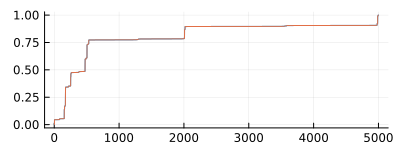

In [311]:
trs = state.traces
ws  = state.log_weights;
scores = get_score.(trs)

println(size(filter(isnan, ws)))
println(size(filter(isinf, ws)))
println(size(filter(isnan, scores)))
println(size(filter(isinf, scores)))



perm = sortperm(ws)
trs = trs[perm]
ws  = ws[perm]
scores = scores[perm]

ws     = peak_to_peak(ws)
scores = peak_to_peak(scores)

plot(size=(400,150), legend=nothing)
plot!(ws)
plot!(scores)

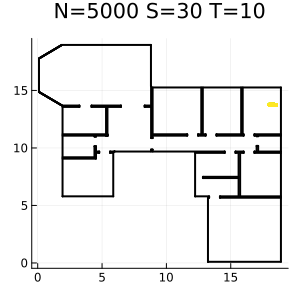

In [312]:
# ---------------------------
myplot = plot(size=(300,300), legend=nothing,  fmt = :png, title="N=$(N) S=$(S) T=$(T)")

num_scatter = 50
for (tr,w,sc) in zip(trs[end-num_scatter:end],ws[end-num_scatter:end],scores[end-num_scatter:end])
    r = tr[]
    p = r[1][1]
    plot!([p.x,p.x + 0.5*unit_vec(p.hd)], c=cgrad(:viridis)[w], linewidth=4)
end
plot!(_segs, c=:black, linewidth=2)
# savefig("_imgs/skip_measures_N$(N)_S$(S)_T$(T)_i$(i).png")
display(myplot)

In [313]:
function plot_static_tr(tr::StaticIRTrace)
    T, _, a_, = get_args(tr)
    
    a = Array(a_)
    rs = tr[]
    ps = [r[1] for r in rs]
    ss = [Measurement.(r[2],a) for r in rs]
    
    myplot = plot(aspect_ratio=:equal)
    plot!(_segs, label=nothing, c=:black)

    for t=1:T
        scatter!([ps[t].x], label=nothing, c=col[1])
        scatter!(ps[t],ss[t], markerstrokewidth=0.0, c=col[2], alpha=0.25, label=nothing)
    end
    return myplot
end

plot_static_tr (generic function with 1 method)

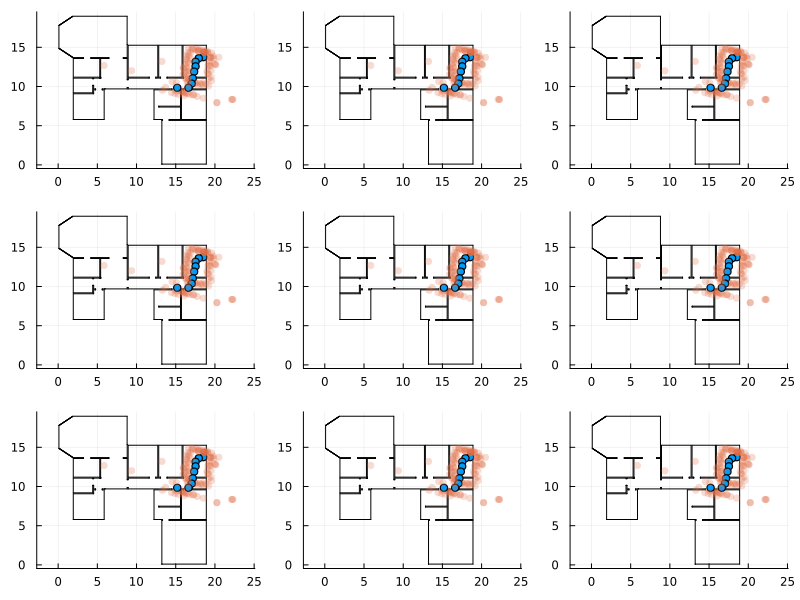

In [314]:
plot([plot_static_tr(tr) for tr in trs[end-9+1:end]]..., layout=(3, 3), size=(800,600))